## Preliminaries

In [1]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505175 sha256=e1e103bd041b16a461a531fab52d57721dc73a60667d41b37fb6a484e000f82d
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [2]:
# Load in libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from surprise import KNNWithMeans
from surprise import Dataset, NormalPredictor, Reader, accuracy
from surprise.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

## Question 1

In [3]:
# Load in dataset
df = pd.read_csv('ratings.csv')
# df.head()

# Create ratings matrix
rating_matrix = df.pivot(index='userId', columns='movieId', values='rating')
rating_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Part A
# Compute sparsity of movie rating dataset
num_ratings = np.count_nonzero(~rating_matrix.isnull())
num_users = rating_matrix.shape[0]
num_movies = rating_matrix.shape[1]
sparsity = (num_ratings / (num_users * num_movies))
print("Sparsity: ", sparsity)

Sparsity:  0.016999683055613623


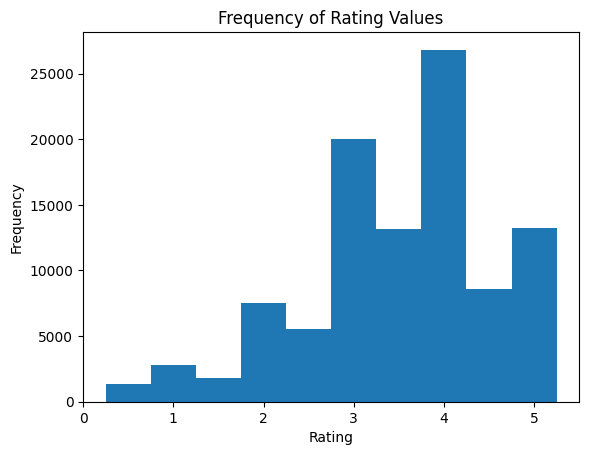

In [ ]:
# Part B
# Histogram of frequency of rating values
rating_freq = rating_matrix.stack().value_counts()

# Create histogram with bins of width 0.5
plt.bar(rating_freq.index, rating_freq.values, width = 0.5)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Frequency of Rating Values')
plt.show()

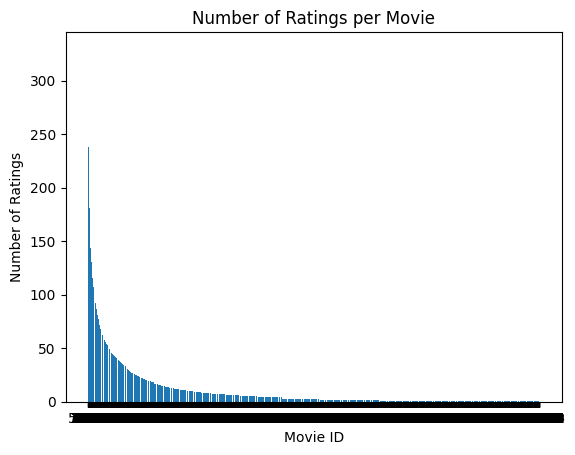

In [ ]:
# Part c (takes a minute or two to run)
# Plot distribution of the number of ratings received among movies

# Count number of ratings for each movieId and sort
movie_counts = df['movieId'].value_counts().sort_values(ascending = False)

# Convert movieIds to string to force them to be categorical
movie_counts.index = movie_counts.index.astype(str)

# Plot
plt.bar(movie_counts.index, movie_counts.values)
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings per Movie')
plt.show()

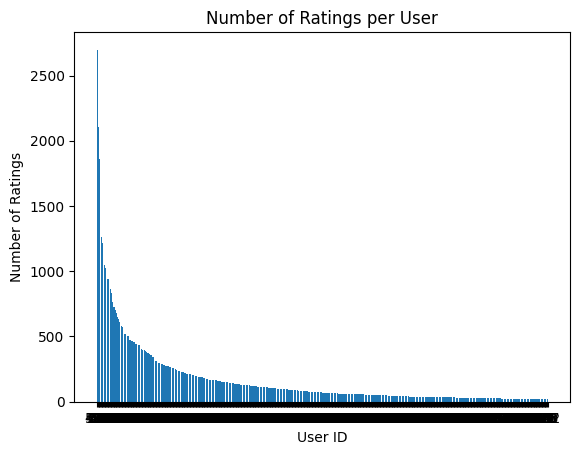

In [ ]:
# Part d
# Plot distribution of the number of ratings received among users

# Count number of ratings for each userId and sort
user_counts = df['userId'].value_counts().sort_values(ascending = False)

# Convert userIds to string to force them to be categorical
user_counts.index = user_counts.index.astype(str)

# Plot
plt.bar(user_counts.index, user_counts.values)
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings per User')
plt.show()

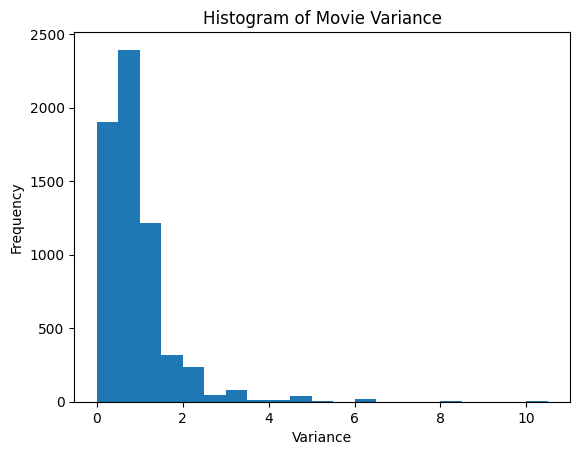

In [ ]:
# Part f
# Compute the variance of rating values received by each movie

# Get variances per movieId
movie_variance = df.groupby('movieId')['rating'].var().dropna()

# Plot histogram
binwidth = 0.5
plt.hist(movie_variance, bins = np.arange(min(movie_variance), max(movie_variance) + binwidth, binwidth))
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title('Histogram of Movie Variance')
plt.show()

## Question 2

### Part a
$$\mu_u = \frac{1}{|I_u|}\Sigma_{k \in I_u}r_{u,k}$$

### Part b
$I_u \cap I_v$ represents the set of movies that have been rated by both users $u$ and $v$. It is possible for $I_u \cap I_v = \emptyset$ if users $u$ and $v$ have not rated any movies in common. For a sparse matrix with many movies and many users, it is likely that there will be at least one pair of users who have not rated any movie in common.

## Question 3

$$\hat{r}_{uj} = \mu_u + \frac{\Sigma_{v \in P_u}Pearson(u, v)(r_{vj} - \mu_v)}{\Sigma_{v \in P_u}|Pearson(u, v)|}$$

The purpose of mean-centering the raw ratings $(r_{vj} - \mu_v)$ is that we are interested in deviations from the mean. A naïve first guess for a user's rating could just be the average rating. We can improve this first guess by looking at highly correlated (similar) users and shift the guess accordingly based on the users' ratings' deviation from the mean.

Another perspective is to consider users who tend to only give extreme ratings. If we use absolute rating scales, this can lead to these users biases influencing the predicted user's rating. For example, if we are trying to predict a user's rating and the user tends to be ambivalent, using users who constantly give ratings of 5 would bias the predicted rating upward not because of similarity, but because of the fact that the users give extreme ratings.

## Question 4

In [ ]:
# Load in data
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# Define cross-validation iterator
kf = KFold(n_splits = 10)

In [ ]:
# Number of neighbors = 2, 4, 6, ..., 98, 100
k_values = np.arange(2, 102, 2)

# Keep track of RMSE and MAE
rmse_values = []
mae_values = []

# Iterate over k values (about 12 minutes to run)
for k in tqdm(k_values):

    # Initialize algorithm
    algo = KNNWithMeans(k, sim_options = {"name" : "pearson"}, verbose = False)

    # Get RMSE and MAE values for given k
    rmse_val = []
    mae_val = []

    for trainset, testset in kf.split(data):

        # Train and test algorithm
        algo.fit(trainset)
        predictions = algo.test(testset)

        # Compute RMSE and MAE
        rmse_val.append(accuracy.rmse(predictions, verbose = False))
        mae_val.append(accuracy.mae(predictions, verbose = False))

    # Compute average RMSE and MAE
    rmse_values.append(np.mean(rmse_val))
    mae_values.append(np.mean(mae_val))

100%|██████████| 50/50 [11:21<00:00, 13.63s/it]


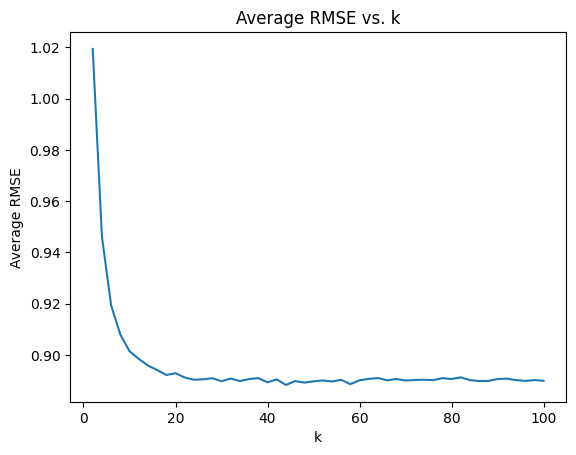

In [ ]:
# Plot average RMSE vs. k
plt.plot(k_values, rmse_values)
plt.xlabel('k')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs. k')
plt.show()

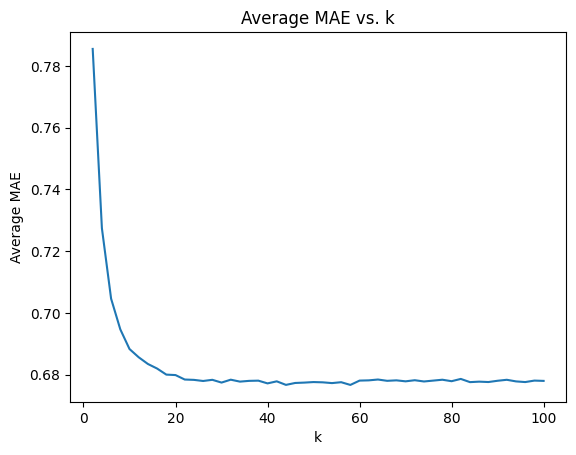

In [ ]:
# Plot average MAE vs. k
plt.plot(k_values, mae_values)
plt.xlabel('k')
plt.ylabel('Average MAE')
plt.title('Average MAE vs. k')
plt.show()

## Question 5

In [ ]:
# Find k value where RMSE and MAE reach steady state values
# (as defined by very small absolute changes in RMSE and MAE below some threshold)
threshold = 0.0005
k_values = np.arange(2, 102, 2)
rmse_values = np.array(rmse_values)
mae_values = np.array(mae_values)

# Find indices where RMSE and MAE change below threshold
rmse_indices = np.where(np.abs(np.diff(rmse_values)) < threshold)[0] + 1
mae_indices = np.where(np.abs(np.diff(mae_values)) < threshold)[0] + 1

# Get first index
rmse_index = rmse_indices[0]
mae_index = mae_indices[0]

# Get corresponding k values
k_rmse = k_values[rmse_index]
k_mae = k_values[mae_index]

# Print k values
# print("k value where RMSE reaches steady state: ", k_rmse)
# print("k value where MAE reaches steady state: ", k_mae)

# Report corresponding RMSE and MAE values
print("RMSE value at k =", k_rmse, ":", rmse_values[rmse_index])
print("MAE value at k =", k_mae, ":", mae_values[mae_index])

RMSE value at k = 26 : 0.890496911654892
MAE value at k = 20 : 0.679847788055899


We define the "minimum k" as the  value for k such that the RMSE (or MSE) changes by less than 0.0005.

## Question 6

In [4]:
# Popular movie trimming
# Keep movies with more than 2 ratings
rating_matrix_popular = rating_matrix.copy()
rating_matrix_popular = rating_matrix_popular.loc[:, rating_matrix.count() > 2]

# Unpoular movie trimming
# Keep movies with 2 or fewer ratings
rating_matrix_unpopular = rating_matrix.copy()
rating_matrix_unpopular = rating_matrix_unpopular.loc[:, rating_matrix.count() <= 2]

# High variance movie trimming
# Keep movies with at least 5 ratings and have variance at least 2
rating_matrix_high_variance = rating_matrix.copy()
rating_matrix_high_variance = rating_matrix_high_variance.loc[:, rating_matrix_high_variance.count() >= 5]
rating_matrix_high_variance = rating_matrix_high_variance.loc[:, rating_matrix_high_variance.var() >= 2]

# Print final shapes
# print("Original shape: ", rating_matrix.shape)
# print("Final shape of popular movie matrix: ", rating_matrix_popular.shape)
# print("Final shape of unpopular movie matrix: ", rating_matrix_unpopular.shape)
# print("Final shape of high variance movie matrix: ", rating_matrix_high_variance.shape)

In [5]:
# Get movieId values
popular_movies = rating_matrix_popular.columns
unpopular_movies = rating_matrix_unpopular.columns
high_variance_movies = rating_matrix_high_variance.columns

# Filter df based on movieId values
df_popular = df[df['movieId'].isin(popular_movies)]
df_unpopular = df[df['movieId'].isin(unpopular_movies)]
df_high_variance = df[df['movieId'].isin(high_variance_movies)]

100%|██████████| 50/50 [11:21<00:00, 13.64s/it]


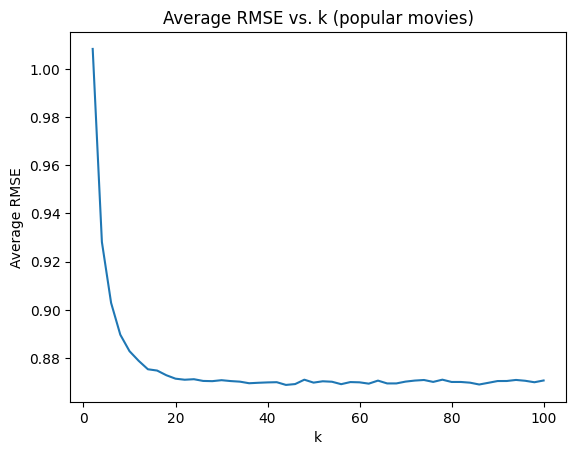

Minimum RMSE:  0.8688494022558348
Corresponding k value:  44


In [ ]:
### Popular movies
# Load in data
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df_popular[['userId', 'movieId', 'rating']], reader)

# Define cross-validation iterator
kf = KFold(n_splits = 10)

# Number of neighbors = 2, 4, 6, ..., 98, 100
k_values = np.arange(2, 102, 2)

# Keep track of RMSE and MAE
rmse_values = []
mae_values = []

# Iterate over k values (about 11 minutes to run)
for k in tqdm(k_values):

    # Initialize algorithm
    algo = KNNWithMeans(k, sim_options = {"name" : "pearson"}, verbose = False)

    # Get RMSE and MAE values for given k
    rmse_val = []
    mae_val = []

    for trainset, testset in kf.split(data):

        # Train and test algorithm
        algo.fit(trainset)
        predictions = algo.test(testset)

        # Compute RMSE and MAE
        rmse_val.append(accuracy.rmse(predictions, verbose = False))
        mae_val.append(accuracy.mae(predictions, verbose = False))

    # Compute average RMSE and MAE
    rmse_values.append(np.mean(rmse_val))
    mae_values.append(np.mean(mae_val))

# Plot average RMSE vs. k
plt.plot(k_values, rmse_values)
plt.xlabel('k')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs. k (popular movies)')
plt.show()

# Display minimum RMSE and corresponding k value
print("Minimum RMSE: ", np.min(rmse_values))
print("Corresponding k value: ", k_values[np.argmin(rmse_values)])

100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


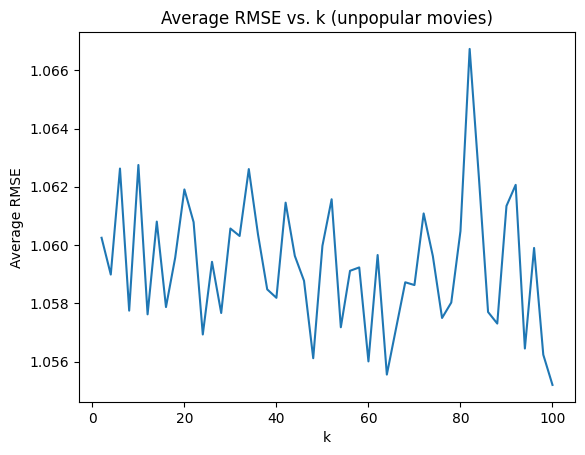

Minimum RMSE:  1.0551981146110472
Corresponding k value:  100


In [ ]:
### Unpopular movies
# Load in data
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df_unpopular[['userId', 'movieId', 'rating']], reader)

# Define cross-validation iterator
kf = KFold(n_splits = 10)

# Number of neighbors = 2, 4, 6, ..., 98, 100
k_values = np.arange(2, 102, 2)

# Keep track of RMSE and MAE
rmse_values = []
mae_values = []

# Iterate over k values (about 20 seconds)
for k in tqdm(k_values):

    # Initialize algorithm
    algo = KNNWithMeans(k, sim_options = {"name" : "pearson"}, verbose = False)

    # Get RMSE and MAE values for given k
    rmse_val = []
    mae_val = []

    for trainset, testset in kf.split(data):

        # Train and test algorithm
        algo.fit(trainset)
        predictions = algo.test(testset)

        # Compute RMSE and MAE
        rmse_val.append(accuracy.rmse(predictions, verbose = False))
        mae_val.append(accuracy.mae(predictions, verbose = False))

    # Compute average RMSE and MAE
    rmse_values.append(np.mean(rmse_val))
    mae_values.append(np.mean(mae_val))

# Plot average RMSE vs. k
plt.plot(k_values, rmse_values)
plt.xlabel('k')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs. k (unpopular movies)')
plt.show()

# Display minimum RMSE and corresponding k value
print("Minimum RMSE: ", np.min(rmse_values))
print("Corresponding k value: ", k_values[np.argmin(rmse_values)])

100%|██████████| 50/50 [00:01<00:00, 26.50it/s]


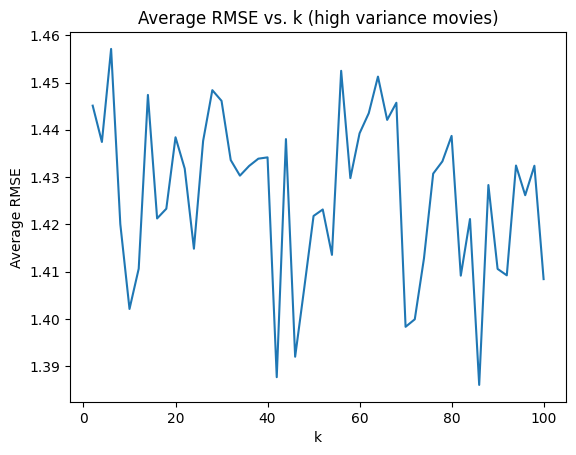

Minimum RMSE:  1.3860131171482812
Corresponding k value:  86


In [ ]:
### High variance movies
# Load in data
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df_high_variance[['userId', 'movieId', 'rating']], reader)

# Define cross-validation iterator
kf = KFold(n_splits = 10)

# Number of neighbors = 2, 4, 6, ..., 98, 100
k_values = np.arange(2, 102, 2)

# Keep track of RMSE and MAE
rmse_values = []
mae_values = []

# Iterate over k values (very fast)
for k in tqdm(k_values):

    # Initialize algorithm
    algo = KNNWithMeans(k, sim_options = {"name" : "pearson"}, verbose = False)

    # Get RMSE and MAE values for given k
    rmse_val = []
    mae_val = []

    for trainset, testset in kf.split(data):

        # Train and test algorithm
        algo.fit(trainset)
        predictions = algo.test(testset)

        # Compute RMSE and MAE
        rmse_val.append(accuracy.rmse(predictions, verbose = False))
        mae_val.append(accuracy.mae(predictions, verbose = False))

    # Compute average RMSE and MAE
    rmse_values.append(np.mean(rmse_val))
    mae_values.append(np.mean(mae_val))

# Plot average RMSE vs. k
plt.plot(k_values, rmse_values)
plt.xlabel('k')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs. k (high variance movies)')
plt.show()

# Display minimum RMSE and corresponding k value
print("Minimum RMSE: ", np.min(rmse_values))
print("Corresponding k value: ", k_values[np.argmin(rmse_values)])

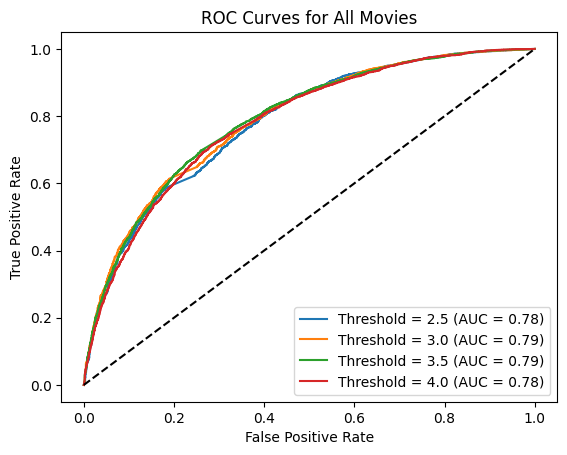

In [26]:
# ROC Curves
# Choose k = 26 since it was the minimum k value using RMSE from question 5

# Parameters
k = 26
thresholds = [2.5, 3.0, 3.5, 4.0]
datasets = ["df", "df_popular", "df_unpopular", "df_high_variance"]

dataset = df
dataset_label = "df"

# Prepare overlaying plots
fig, ax = plt.subplots()

# Load in data
reader = Reader(rating_scale = (0.5, 5))
data = Dataset.load_from_df(dataset[['userId', 'movieId', 'rating']], reader)

# Train/Test split
trainset, testset = train_test_split(data, test_size = 0.1, random_state = 0)

# Run algorithm
algo = KNNWithMeans(k, sim_options = {"name" : "pearson"}, verbose = False)
results = algo.fit(trainset).test(testset)

# Thresholding
for threshold in thresholds:
  threshold_pos = []
  for row in results:
    if row.r_ui >= threshold:
      threshold_pos.append(1)
    else:
      threshold_pos.append(0)

  # Get ROC Curve values
  fpr, tpr, thresholds = roc_curve(threshold_pos, [row.est for row in results])
  auc_value = auc(fpr, tpr)

  # Plot for each threshold
  if threshold == 2.5:
    ax.plot(fpr, tpr, label = 'Threshold = 2.5 (AUC = %0.2f)' % auc_value)
  elif threshold == 3.:
    ax.plot(fpr, tpr, label = 'Threshold = 3.0 (AUC = %0.2f)' % auc_value)
  elif threshold == 3.5:
    ax.plot(fpr, tpr, label = 'Threshold = 3.5 (AUC = %0.2f)' % auc_value)
  else:
    ax.plot(fpr, tpr, label = 'Threshold = 4.0 (AUC = %0.2f)' % auc_value)

  # Label results
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  # Set title for given threshold
  ax.set_title('ROC Curves for All Movies')
  ax.legend(loc = "best")

# Plot chance
ax.plot([0, 1], [0, 1], 'k--')

# Show plot
plt.show()

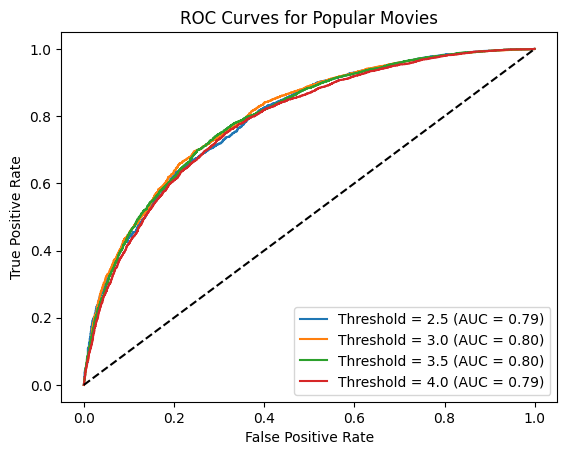

In [23]:
# ROC Curves
# Choose k = 26 since it was the minimum k value using RMSE from question 5

# Parameters
k = 26
thresholds = [2.5, 3.0, 3.5, 4.0]
datasets = ["df", "df_popular", "df_unpopular", "df_high_variance"]

dataset = df_popular
dataset_label = "df_popular"

# Prepare overlaying plots
fig, ax = plt.subplots()

# Load in data
reader = Reader(rating_scale = (0.5, 5))
data = Dataset.load_from_df(dataset[['userId', 'movieId', 'rating']], reader)

# Train/Test split
trainset, testset = train_test_split(data, test_size = 0.1, random_state = 0)

# Run algorithm
algo = KNNWithMeans(k, sim_options = {"name" : "pearson"}, verbose = False)
results = algo.fit(trainset).test(testset)

# Thresholding
for threshold in thresholds:
  threshold_pos = []
  for row in results:
    if row.r_ui >= threshold:
      threshold_pos.append(1)
    else:
      threshold_pos.append(0)

  # Get ROC Curve values
  fpr, tpr, thresholds = roc_curve(threshold_pos, [row.est for row in results])
  auc_value = auc(fpr, tpr)

  # Plot for each threshold
  if threshold == 2.5:
    ax.plot(fpr, tpr, label = 'Threshold = 2.5 (AUC = %0.2f)' % auc_value)
  elif threshold == 3.:
    ax.plot(fpr, tpr, label = 'Threshold = 3.0 (AUC = %0.2f)' % auc_value)
  elif threshold == 3.5:
    ax.plot(fpr, tpr, label = 'Threshold = 3.5 (AUC = %0.2f)' % auc_value)
  else:
    ax.plot(fpr, tpr, label = 'Threshold = 4.0 (AUC = %0.2f)' % auc_value)

  # Label results
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  # Set title for given threshold
  ax.set_title('ROC Curves for Popular Movies')
  ax.legend(loc = "best")

# Plot chance
ax.plot([0, 1], [0, 1], 'k--')

# Show plot
plt.show()

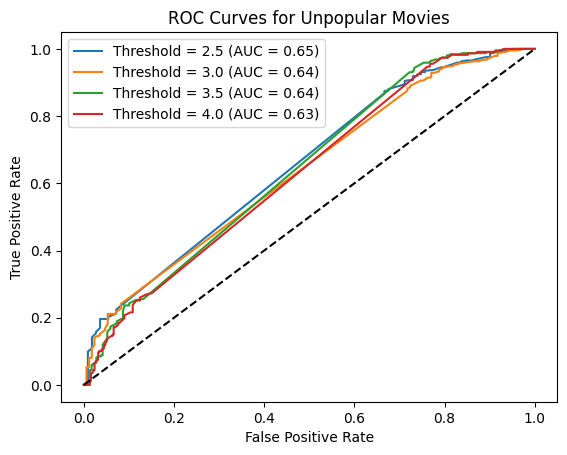

In [24]:
# ROC Curves
# Choose k = 26 since it was the minimum k value using RMSE from question 5

# Parameters
k = 26
thresholds = [2.5, 3.0, 3.5, 4.0]
datasets = ["df", "df_popular", "df_unpopular", "df_high_variance"]

dataset = df_unpopular
dataset_label = "df_unpopular"

# Prepare overlaying plots
fig, ax = plt.subplots()

# Load in data
reader = Reader(rating_scale = (0.5, 5))
data = Dataset.load_from_df(dataset[['userId', 'movieId', 'rating']], reader)

# Train/Test split
trainset, testset = train_test_split(data, test_size = 0.1, random_state = 0)

# Run algorithm
algo = KNNWithMeans(k, sim_options = {"name" : "pearson"}, verbose = False)
results = algo.fit(trainset).test(testset)

# Thresholding
for threshold in thresholds:
  threshold_pos = []
  for row in results:
    if row.r_ui >= threshold:
      threshold_pos.append(1)
    else:
      threshold_pos.append(0)

  # Get ROC Curve values
  fpr, tpr, thresholds = roc_curve(threshold_pos, [row.est for row in results])
  auc_value = auc(fpr, tpr)

  # Plot for each threshold
  if threshold == 2.5:
    ax.plot(fpr, tpr, label = 'Threshold = 2.5 (AUC = %0.2f)' % auc_value)
  elif threshold == 3.:
    ax.plot(fpr, tpr, label = 'Threshold = 3.0 (AUC = %0.2f)' % auc_value)
  elif threshold == 3.5:
    ax.plot(fpr, tpr, label = 'Threshold = 3.5 (AUC = %0.2f)' % auc_value)
  else:
    ax.plot(fpr, tpr, label = 'Threshold = 4.0 (AUC = %0.2f)' % auc_value)

  # Label results
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  # Set title for given threshold
  ax.set_title('ROC Curves for Unpopular Movies')
  ax.legend(loc = "best")

# Plot chance
ax.plot([0, 1], [0, 1], 'k--')

# Show plot
plt.show()

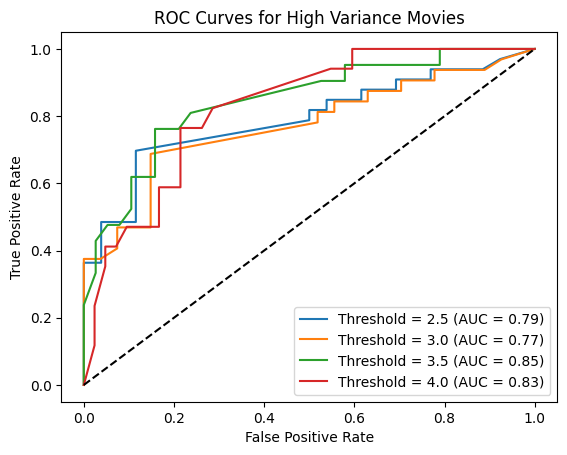

In [25]:
# ROC Curves
# Choose k = 26 since it was the minimum k value using RMSE from question 5

# Parameters
k = 26
thresholds = [2.5, 3.0, 3.5, 4.0]
datasets = ["df", "df_popular", "df_unpopular", "df_high_variance"]

dataset = df_high_variance
dataset_label = "df_high_variance"

# Prepare overlaying plots
fig, ax = plt.subplots()

# Load in data
reader = Reader(rating_scale = (0.5, 5))
data = Dataset.load_from_df(dataset[['userId', 'movieId', 'rating']], reader)

# Train/Test split
trainset, testset = train_test_split(data, test_size = 0.1, random_state = 0)

# Run algorithm
algo = KNNWithMeans(k, sim_options = {"name" : "pearson"}, verbose = False)
results = algo.fit(trainset).test(testset)

# Thresholding
for threshold in thresholds:
  threshold_pos = []
  for row in results:
    if row.r_ui >= threshold:
      threshold_pos.append(1)
    else:
      threshold_pos.append(0)

  # Get ROC Curve values
  fpr, tpr, thresholds = roc_curve(threshold_pos, [row.est for row in results])
  auc_value = auc(fpr, tpr)

  # Plot for each threshold
  if threshold == 2.5:
    ax.plot(fpr, tpr, label = 'Threshold = 2.5 (AUC = %0.2f)' % auc_value)
  elif threshold == 3.:
    ax.plot(fpr, tpr, label = 'Threshold = 3.0 (AUC = %0.2f)' % auc_value)
  elif threshold == 3.5:
    ax.plot(fpr, tpr, label = 'Threshold = 3.5 (AUC = %0.2f)' % auc_value)
  else:
    ax.plot(fpr, tpr, label = 'Threshold = 4.0 (AUC = %0.2f)' % auc_value)

  # Label results
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  # Set title for given threshold
  ax.set_title('ROC Curves for High Variance Movies')
  ax.legend(loc = "best")

# Plot chance
ax.plot([0, 1], [0, 1], 'k--')

# Show plot
plt.show()

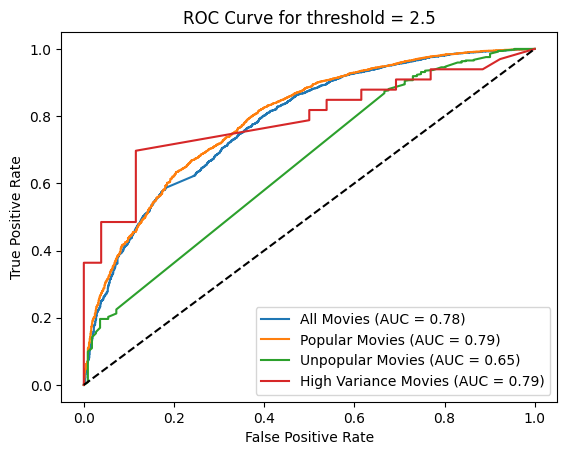

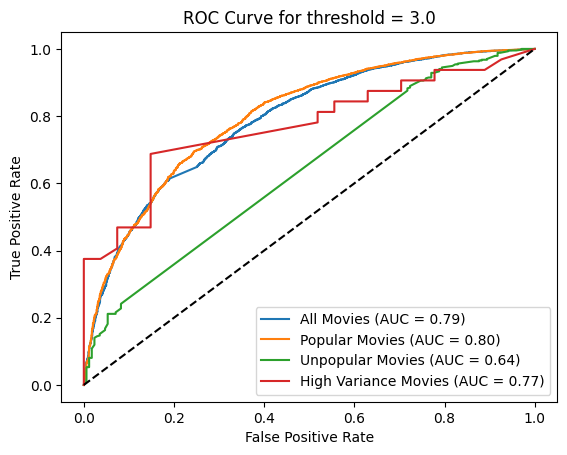

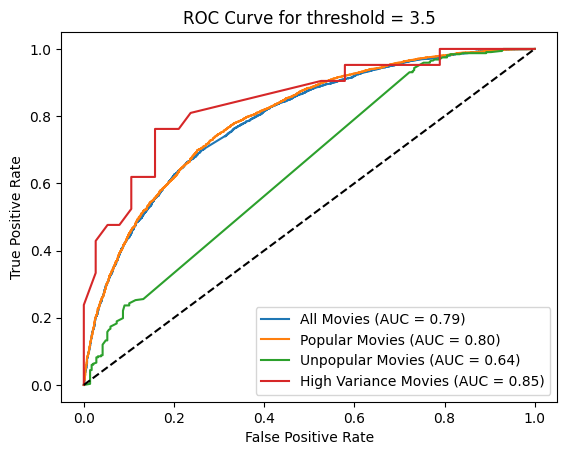

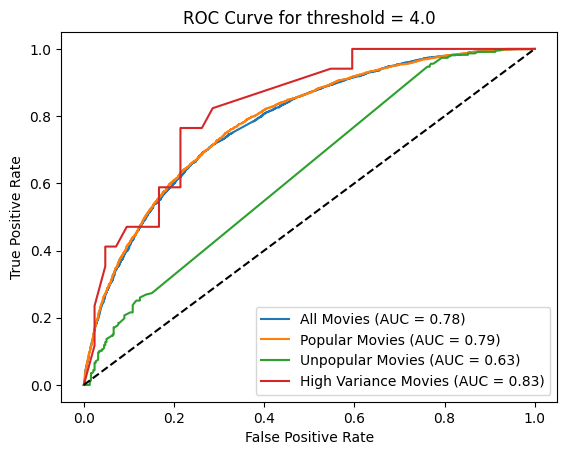

In [8]:
# ROC Curves
# Choose k = 26 since it was the minimum k value using RMSE from question 5

# Parameters
k = 26
thresholds = [2.5, 3.0, 3.5, 4.0]
datasets = ["df", "df_popular", "df_unpopular", "df_high_variance"]

# Iterate through each threshold
for threshold in thresholds:

  # Prepare overlaying plots
  fig, ax = plt.subplots()

  # Perform algorithm
  for dataset in datasets:

    # Select dataset
    if dataset == "df":
      dataset = df
      dataset_label = "df"
    elif dataset == "df_popular":
      dataset = df_popular
      dataset_label = "df_popular"
    elif dataset == "df_unpopular":
      dataset = df_unpopular
      dataset_label = "df_unpopular"
    else:
      dataset = df_high_variance
      dataset_label = "df_high_variance"

    # Load in data
    reader = Reader(rating_scale = (0.5, 5))
    data = Dataset.load_from_df(dataset[['userId', 'movieId', 'rating']], reader)

    # Train/Test split
    trainset, testset = train_test_split(data, test_size = 0.1, random_state = 0)

    # Run algorithm
    algo = KNNWithMeans(k, sim_options = {"name" : "pearson"}, verbose = False)
    results = algo.fit(trainset).test(testset)

    # Thresholding
    threshold_pos = []
    for row in results:
      if row.r_ui >= threshold:
        threshold_pos.append(1)
      else:
        threshold_pos.append(0)

    # Get ROC Curve values
    fpr, tpr, thresholds = roc_curve(threshold_pos, [row.est for row in results])
    auc_value = auc(fpr, tpr)

    # Plot for each dataset
    if dataset_label == "df":
      ax.plot(fpr, tpr, label = 'All Movies (AUC = %0.2f)' % auc_value)
    elif dataset_label == "df_popular":
      ax.plot(fpr, tpr, label = 'Popular Movies (AUC = %0.2f)' % auc_value)
    elif dataset_label == "df_unpopular":
      ax.plot(fpr, tpr, label = 'Unpopular Movies (AUC = %0.2f)' % auc_value)
    else:
      ax.plot(fpr, tpr, label = 'High Variance Movies (AUC = %0.2f)' % auc_value)

    # Label results
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    # Set title for given threshold
    ax.set_title('ROC Curve for threshold = ' + str(threshold))
    ax.legend()

  # Plot chance
  ax.plot([0, 1], [0, 1], 'k--')

  # Show plot
  plt.show()